In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [3]:
# Take the SW > 19
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(19,36))]

In [4]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [5]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells200_10-10.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on SWISS 19-35 with father : threshold 300

In [6]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/dict_results_across_mice_SW19-35-200_10-10.npy', dict_results_across_mice)

In [7]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_SW19-35-200_10-10.npy', allow_pickle=True).item()

In [ ]:
# removed key corresponding to SW21_Fam
dict_results_across_mice.pop('SW21_Fam')

In [13]:
subjects.remove('SW21_Fam')

# List areas with null cell count

In [14]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [15]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [16]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW25_Control',
  'SW19_Control',
  'SW24_Control',
  'SW31_Control',
  'SW30_Control'],
 'Unfam': ['SW26_Unfam',
  'SW20_Unfam',
  'SW22_Unfam',
  'SW28_Unfam',
  'SW34_Unfam',
  'SW32_Unfam'],
 'Fam': ['SW27_Fam', 'SW23_Fam', 'SW29_Fam', 'SW33_Fam', 'SW35_Fam']}

# Calculate cell count across experimental groups

In [17]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [18]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,NaN,NaN,NaN
1,Primary motor area,0.541741,0.973725,0.357891
2,Secondary motor area,0.634172,0.908405,0.639975
3,Primary somatosensory area,0.322849,0.620334,0.37448
4,Supplemental somatosensory area,0.210762,0.8646,0.265871
...,...,...,...,...
293,Flocculus,0.42724,0.513724,0.0718057
294,Fastigial nucleus,0.197534,0.109269,0.512912
295,Interposed nucleus,0.126259,0.019384,0.76559
296,Dentate nucleus,NaN,NaN,NaN


In [19]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [20]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Medial preoptic area,0.000250421
Magnocellular nucleus,0.00184141
Bed nucleus of the accessory olfactory tract,0.0028771
Anterior amygdalar area,0.00330951
Medial amygdalar nucleus,0.00596641
Nucleus of the lateral olfactory tract,0.00850634
Fundus of striatum,0.0115372
Nucleus incertus,0.0192778
Medial preoptic nucleus,0.023333


In [21]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Nucleus of the lateral olfactory tract,1.27451e-05
Anterior amygdalar area,4.31466e-05
Medial preoptic nucleus,0.0022602
Medial preoptic area,0.00234336
Fundus of striatum,0.00282101
Central amygdalar nucleus,0.00498783
Magnocellular nucleus,0.00583886
Lateral vestibular nucleus,0.012347
Medial amygdalar nucleus,0.016992


In [22]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Posterior limiting nucleus of the thalamus,0.000199791
Midbrain reticular nucleus retrorubral area,0.0502041
Globus pallidus internal segment,0.0561192
Subparafascicular nucleus,0.069603
Flocculus,0.0718057
Paraventricular nucleus of the thalamus,0.0800596
Lingula (I),0.0825493
Supragenual nucleus,0.0870137
Peripeduncular nucleus,0.0931124


## Mann Whitney Test for comparison across groups

In [23]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,NaN,NaN,NaN
1,Primary motor area,0.417266,0.324038,0.205657
2,Secondary motor area,0.5,0.463632,0.324038
3,Primary somatosensory area,0.201698,0.463632,0.324038
4,Supplemental somatosensory area,0.148135,0.392096,0.205657
...,...,...,...,...
293,Flocculus,0.41548,0.155431,0.0320733
294,Fastigial nucleus,0.338052,0.0414187,0.261408
295,Interposed nucleus,0.105038,0.0414187,0.324038
296,Dentate nucleus,NaN,NaN,NaN


In [24]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [25]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Magnocellular nucleus,0.00557971
Anterior amygdalar area,0.00596262
Fundus of striatum,0.00596262
Bed nucleus of the accessory olfactory tract,0.00609289
Medial preoptic area,0.00609289
Medial preoptic nucleus,0.00609289
Central amygdalar nucleus,0.0107859
Medial amygdalar nucleus,0.0107859
Nucleus of the lateral olfactory tract,0.0107859


In [26]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Lingula (I),0.00370392
Abducens nucleus,0.00377312
Magnocellular nucleus,0.00377312
Nucleus of the lateral olfactory tract,0.00398471
Anterior amygdalar area,0.00398471
Fundus of striatum,0.00398471
Bed nucleus of the accessory olfactory tract,0.00405656
Central amygdalar nucleus,0.00405656
Medial preoptic area,0.00405656


In [27]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:35].set_index('area')

,pval_Fam_vs_Unfam
area,
Posterior limiting nucleus of the thalamus,0.00304896
Nucleus y,0.00785854
Interfascicular nucleus raphe,0.0130595
Locus ceruleus,0.021951
Subparafascicular nucleus,0.0265137
Flocculus,0.0320733
Primary auditory area,0.0320733
Dorsal tegmental nucleus,0.0330077
Midbrain reticular nucleus retrorubral area,0.0333197


## Calculate cross corr across groups per area on cell count

In [28]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

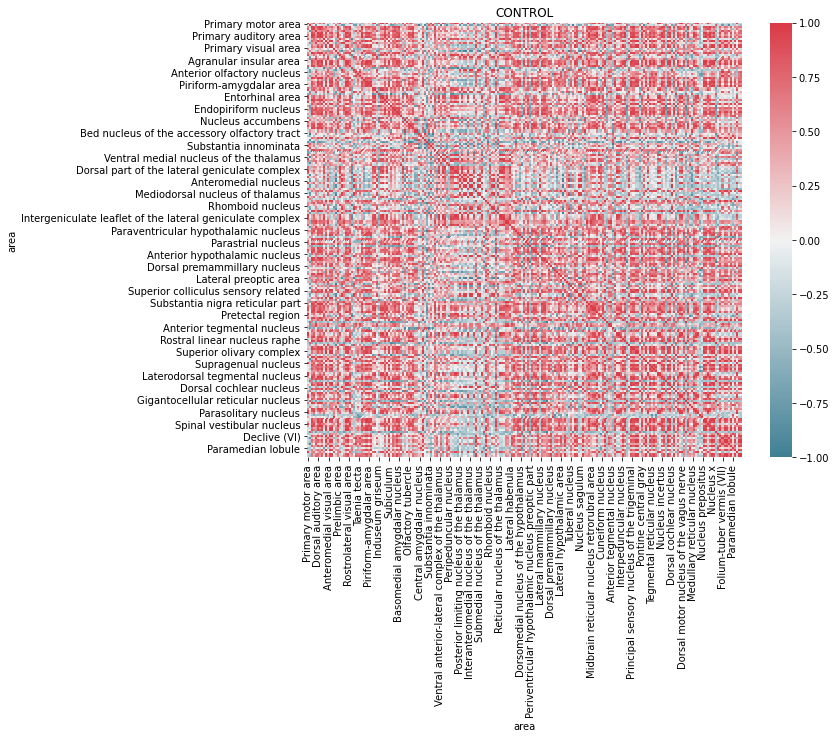

In [29]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

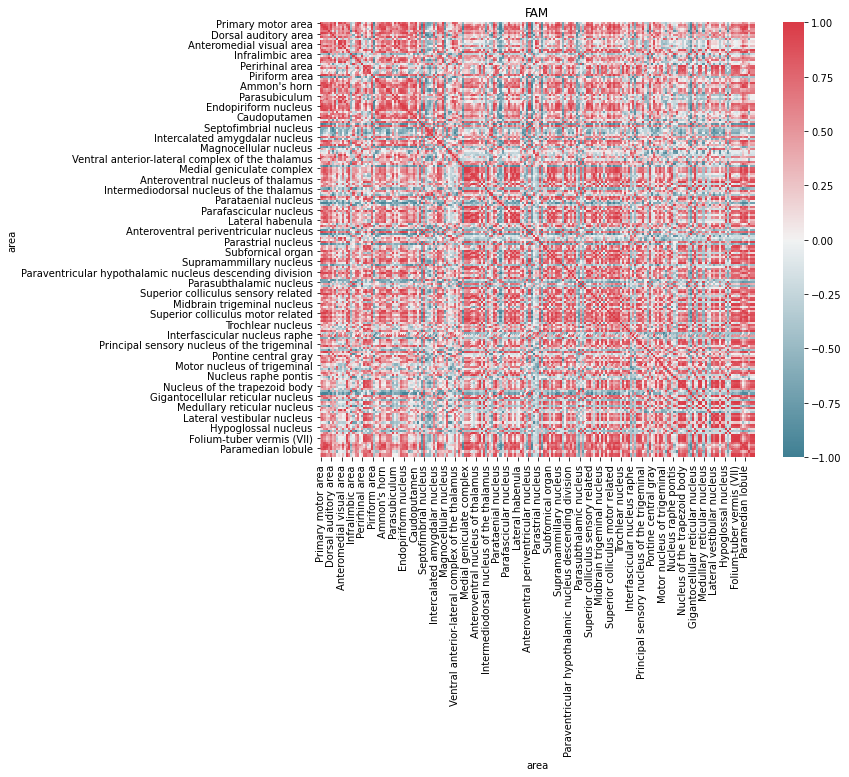

In [30]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

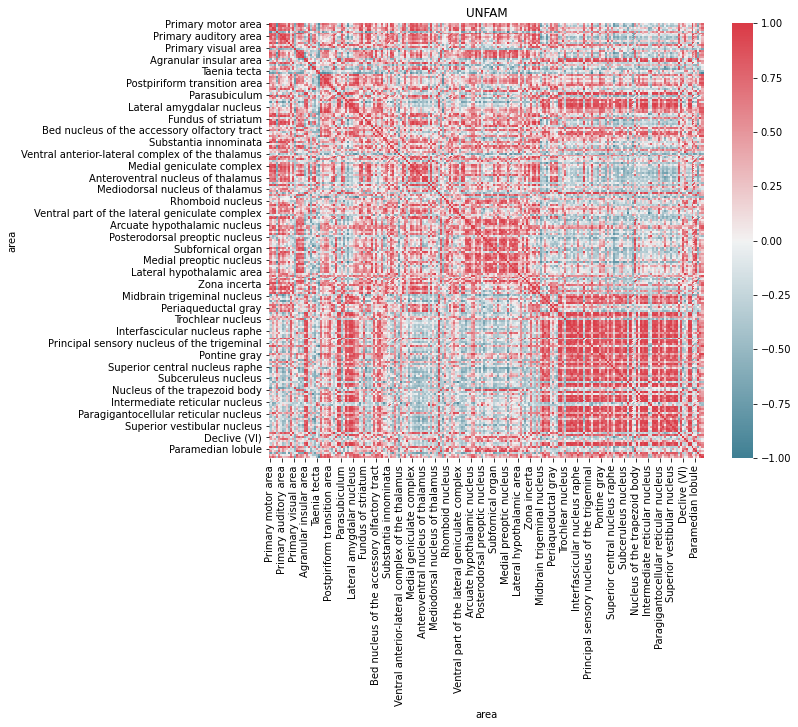

In [31]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [32]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [33]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)

In [34]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [35]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Bed nucleus of the accessory olfactory tract,0.00228688
Medial preoptic area,0.00310897
Medial amygdalar nucleus,0.00522438
Anterior amygdalar area,0.00886595
Nucleus of the lateral olfactory tract,0.00915708
Nucleus incertus,0.00985145
Magnocellular nucleus,0.0115144
Fundus of striatum,0.0175322
Abducens nucleus,0.0431529


In [36]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Anterior amygdalar area,6.86345e-05
Nucleus of the lateral olfactory tract,0.000155626
Medial preoptic nucleus,0.00164179
Medial preoptic area,0.00272057
Fundus of striatum,0.00560327
Magnocellular nucleus,0.0112919
Lateral vestibular nucleus,0.0114035
Central amygdalar nucleus,0.0118024
Interposed nucleus,0.022536


In [37]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Posterior limiting nucleus of the thalamus,0.00156202
Subparafascicular nucleus,0.047082
Interfascicular nucleus raphe,0.0502249
Midbrain reticular nucleus retrorubral area,0.063587
Lateral vestibular nucleus,0.0708785
Locus ceruleus,0.0715131
Paraventricular nucleus of the thalamus,0.0804607
Edinger-Westphal nucleus,0.0850243
Simple lobule,0.0880825


## Mann-Whitney Test across groups

In [38]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')

In [39]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [40]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:40].set_index('area')

,pval_Control_vs_Fam
area,
Accessory abducens nucleus,0.00609289
Fundus of striatum,0.00609289
Lateral strip of striatum,0.00609289
Interstitial nucleus of the vestibular nerve,0.00609289
Anterior amygdalar area,0.00609289
Bed nucleus of the accessory olfactory tract,0.00609289
Medial amygdalar nucleus,0.00609289
Magnocellular nucleus,0.00609289
Retroethmoid nucleus,0.00609289


In [41]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:50].set_index('area')

,pval_Control_vs_Unfam
area,
Abducens nucleus,0.00377312
Lingula (I),0.00377312
Retroethmoid nucleus,0.00405656
Nucleus z,0.00405656
Cochlear nucleus subpedunclular granular region,0.00405656
Granular lamina of the cochlear nuclei,0.00405656
Anterior amygdalar area,0.00405656
Anterior hypothalamic area,0.00405656
Nucleus of the lateral olfactory tract,0.00405656


In [42]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:50].set_index('area')

,pval_Control_vs_Fam
area,
Posterior limiting nucleus of the thalamus,0.0224543
Superior salivatory nucleus,0.00609289
Interstitial nucleus of the vestibular nerve,0.00609289
Suprachiasmatic preoptic nucleus,0.00609289
Pontine reticular nucleus ventral part,0.00609289
Anterior hypothalamic area,0.00609289
Nucleus circularis,0.00609289
Pineal body,0.00609289
Efferent vestibular nucleus,0.00609289


## Calculate cross corr matrix across experimental groups on energy

In [43]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

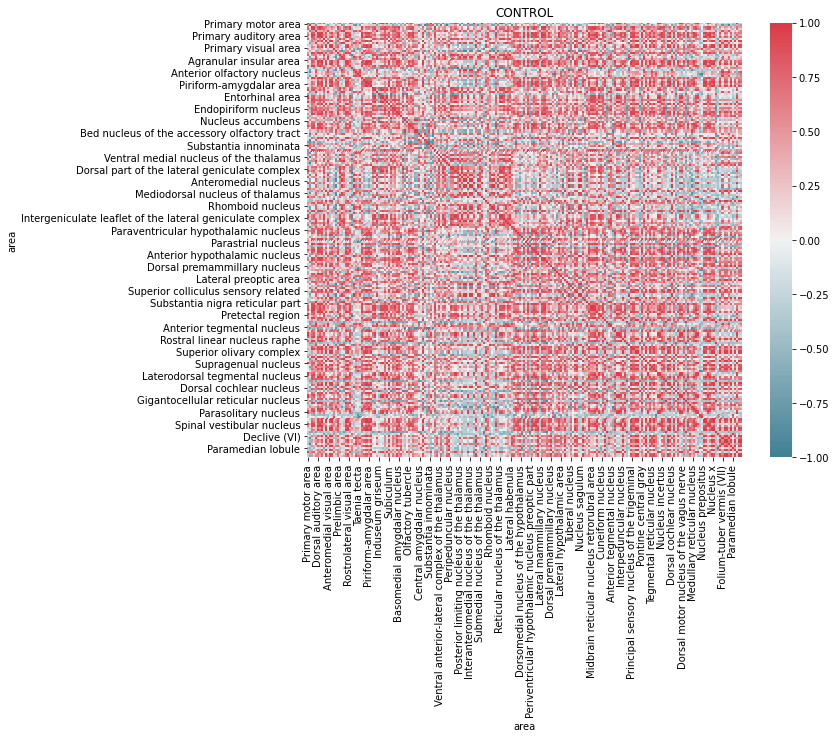

In [44]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

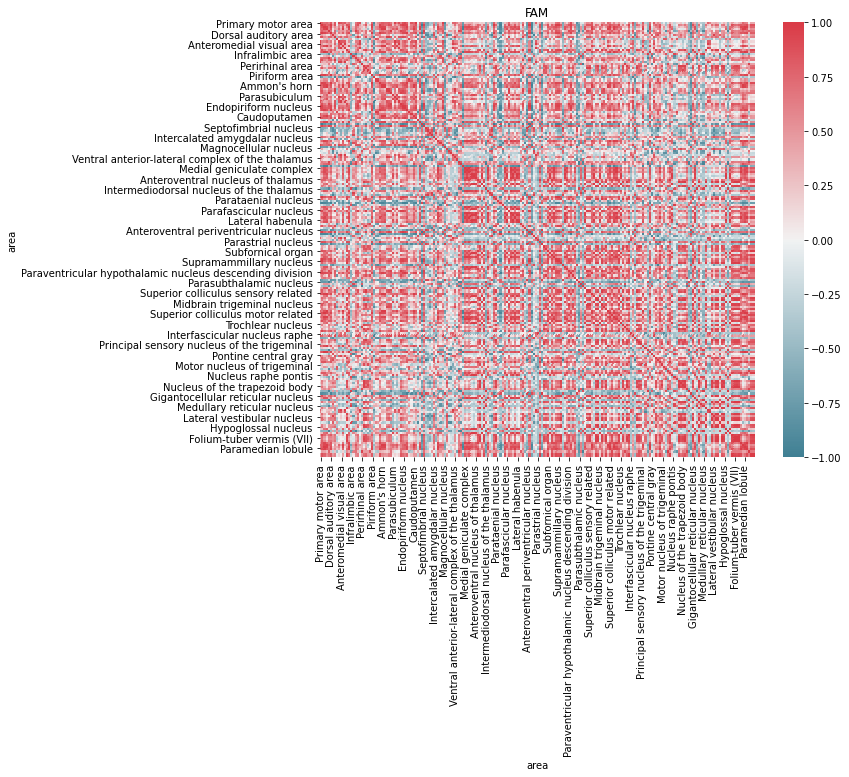

In [45]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

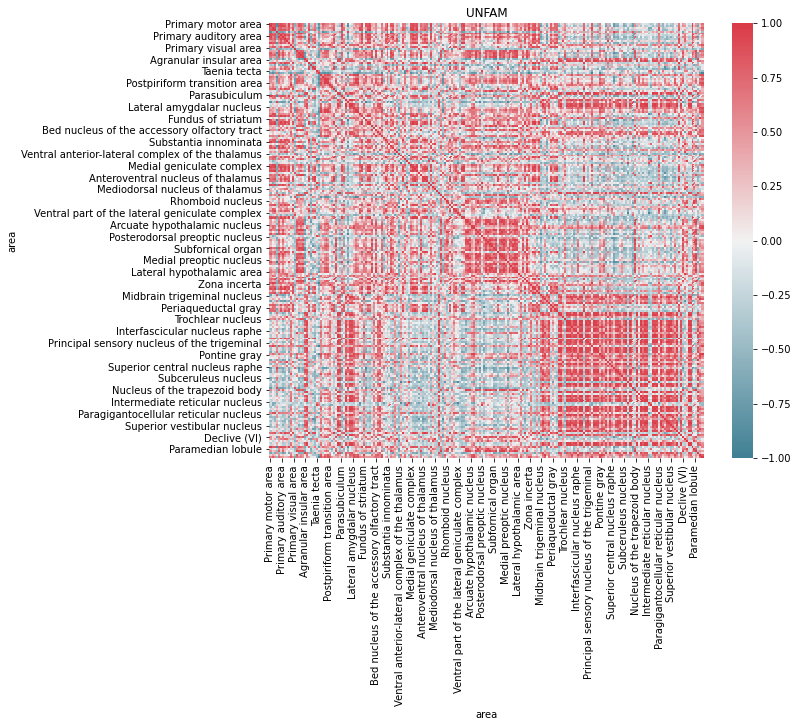

In [46]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')